Inspection of the entire CMC Human clinical data set and its subset that is relevant to our BSM study.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import synapseclient
import fwsel
from bsmcalls import individuals
from bsmcalls import preprocessing
import re

## Data set
### Import and general properties

In [2]:
samples = pd.read_csv('/big/results/bsm/2020-05-18-processed-samples/all_samples.csv')
indivs = list(set(samples['Individual ID']))
indivs.sort()
print(len(samples), 'samples from', len(indivs), 'individuals')

116 samples from 95 individuals


In [3]:
calls, clin = individuals.get_data(merge=False, cols2drop=[])

For the following individuals no somatic variants have been called (yet).

In [4]:
set(indivs) - set(clin.index)

{'CMC_MSSM_033',
 'CMC_MSSM_063',
 'CMC_MSSM_065',
 'CMC_MSSM_164',
 'CMC_MSSM_192',
 'CMC_MSSM_287',
 'CMC_MSSM_309',
 'CMC_MSSM_310',
 'CMC_MSSM_338',
 'CMC_MSSM_405'}

### Variables with missing values

In [5]:
clin.info()

<class 'pandas.core.frame.DataFrame'>
Index: 85 entries, CMC_MSSM_099 to CMC_MSSM_340
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   Institution              85 non-null     category
 1   Reported Gender          85 non-null     category
 2   Sex                      85 non-null     category
 3   Ethnicity                85 non-null     category
 4   ageOfDeath               85 non-null     float64 
 5   Brain Weight (in grams)  84 non-null     float64 
 6   PMI (in hours)           85 non-null     float64 
 7   Dx                       85 non-null     category
 8   Year of Autopsy          85 non-null     float64 
 9   Benzodiazepines          85 non-null     category
 10  Anticonvulsants          85 non-null     category
 11  AntipsychTyp             85 non-null     category
 12  AntipsychAtyp            85 non-null     category
 13  Antidepress              85 non-null     category
 

### ReportedGender and Sex

One of the individuals was a schizophrenic male with Klinefelter syndrome.

In [6]:
clin.groupby(['Reported Gender', 'Sex', 'Dx']).size()

Reported Gender  Sex  Dx     
Female           XX   Control     7
                      SCZ        22
                 XXY  Control     0
                      SCZ         0
                 XY   Control     0
                      SCZ         0
Male             XX   Control     0
                      SCZ         0
                 XXY  Control     0
                      SCZ         1
                 XY   Control    18
                      SCZ        37
dtype: int64

In [7]:
clin.loc[clin['Sex'] == 'XXY', ['Reported Gender', 'Sex']]

,Reported Gender,Sex
CMC_MSSM_213,Male,XXY


Note that there are no transgender individuals with canonical XX or XY chromosomes. It is simpler to keep ReportedGender and drop Sex because the latter is a three level factor whose third level, XXY, occurs only in one individual.  So we could do something like this:

In [8]:
#clin = clin.drop(columns='Sex') # this is essentially the same as "Sex" 

But in what's next we deal with that more systematically.

### Correlation between variables

First we create `clinnum`, a completely numeric version of `clin`, in which the categorical variables have been replaced with the corresponding dummy variables.

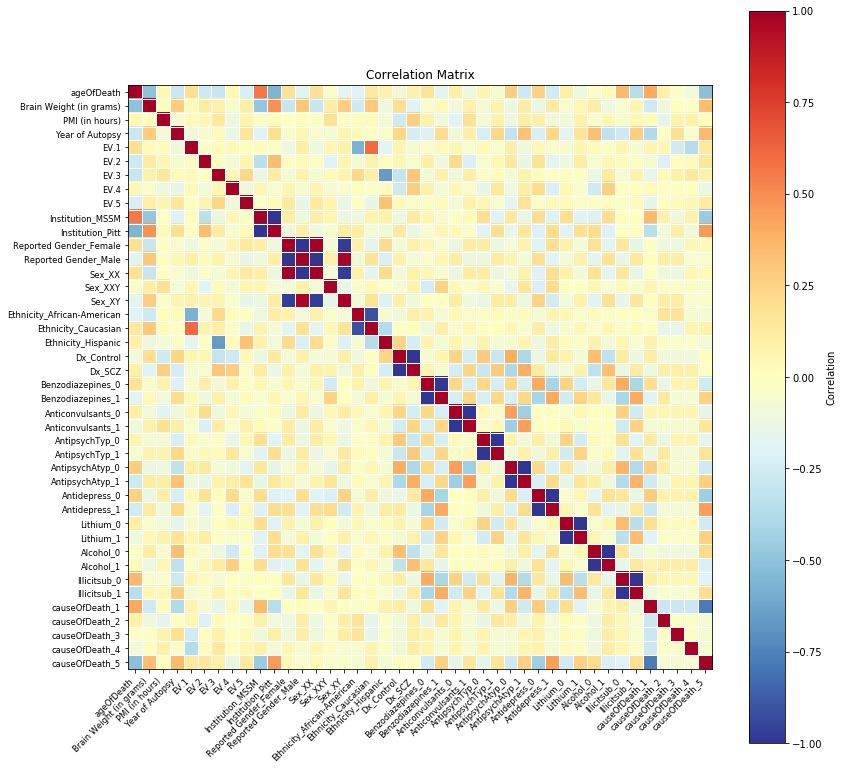

In [9]:
def dummify(df=clin):
    numeric = df.select_dtypes(exclude='category')
    categorical = df.select_dtypes(include='category')
    dummy = pd.get_dummies(categorical)
    dfnum = pd.concat([numeric, dummy], axis=1)
    return(dfnum)

def corrmatplot(dfnum):
    corrmat = dfnum.corr()
    fig, ax = plt.subplots(figsize=(12,12))
    sm.graphics.plot_corr(corrmat, ax=ax, xnames=dfnum.columns, ynames=dfnum.columns)
    cb = plt.colorbar(ax.get_images()[0])
    cb.set_label('Correlation')
    return((fig, ax))

%matplotlib inline
clinnum = dummify(clin)
fig, ax = corrmatplot(clinnum)

The following can be observed:

* Reported Gender and Sex are very strongly correlated as discussed above
* Ethnicity correlates with EV.1 and EV.3
* Level 0 of causeOfDeath is unused (no observations supporting it)
* Further notable correlations:
    * Institution and ageOfDeath
    * DiabetesInsDep and Alcohol (also: DiabetesNonInsDep and Alcohol
    
Conclusion: exclude Sex.  This is implemented now by the `cols2drop=['Sex']` default argument of `bsmcalls.individuals.get_data`.

### Preprocess for modeling

In [10]:
clin1 = preprocessing.preprocess(clin)
clin1

,Institution,ReportedGender,Sex,Ethnicity,ageOfDeath,BrainWeightingrams,PMIinhours,Dx,YearofAutopsy,Benzodiazepines,...,Antidepress,Lithium,Alcohol,Illicitsub,causeOfDeath,EV1,EV2,EV3,EV4,EV5
CMC_MSSM_099,MSSM,Female,XX,African-American,-0.311668,-0.521106,-1.057727,0,0.157623,0,...,1,0,0,0,1,-2.352409,0.121748,0.564939,0.047467,0.367871
CMC_MSSM_352,MSSM,Male,XY,Caucasian,-0.188163,-1.126569,-1.262319,1,-0.621327,0,...,0,0,0,0,1,0.499584,-0.026264,0.225710,0.261236,0.496765
CMC_PITT_024,Pitt,Female,XX,Caucasian,-1.608469,0.674427,-0.065077,1,0.469203,0,...,1,0,0,0,5,0.565168,0.670172,0.171777,0.270921,0.183473
CMC_PITT_052,Pitt,Male,XY,Caucasian,-0.496925,1.880222,0.238022,1,0.936573,0,...,1,0,0,0,5,0.538337,0.537886,0.200020,-0.048272,-0.231317
CMC_MSSM_142,MSSM,Female,XX,Caucasian,0.738123,-0.941852,-1.330516,1,-1.244487,0,...,0,0,1,0,1,0.529806,0.823618,0.082195,-0.280686,0.194008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMC_MSSM_348,MSSM,Female,XX,Caucasian,1.355647,0.104881,1.821715,1,-0.777117,0,...,0,0,0,0,1,0.445518,-2.198854,0.090958,-1.169817,-1.225072
CMC_PITT_064,Pitt,Male,XY,Caucasian,-0.805687,1.213186,0.260754,0,1.248153,0,...,0,0,0,0,1,0.537126,0.790520,0.250359,0.157020,-0.205863
CMC_PITT_082,Pitt,Male,XY,Caucasian,-0.373421,0.930979,-0.345444,0,-0.932907,0,...,0,0,0,0,1,0.539925,0.989394,0.155134,-0.823816,0.866481
CMC_MSSM_027,MSSM,Male,XY,Caucasian,-0.064658,0.027915,-0.671276,1,-1.088697,0,...,0,0,1,0,1,0.475874,-1.023532,0.229492,3.074290,-0.656323


## Modeling
### Forward selection

I used [this implementation](https://planspace.org/20150423-forward_selection_with_statsmodels/) of forward variable selection.  In this implementation the adjusted R-squared statistic was the score that was maximized as the algorithm progressed. 

In [11]:
best = fwsel.forward_selected(clin1, 'Dx')

The results below show that typical and atypical antipsychotics have the most significant "effect" on schizophrenia 

In [12]:
best.model.formula

'Dx ~ AntipsychAtyp + YearofAutopsy + AntipsychTyp + EV3 + Institution + Benzodiazepines + causeOfDeath + Ethnicity + ReportedGender + Alcohol + PMIinhours + BrainWeightingrams + EV1 + EV4 + 1'

In [13]:
best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Dx   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     8.111
Date:                Fri, 21 Aug 2020   Prob (F-statistic):           1.02e-10
Time:                        14:28:49   Log-Likelihood:                -4.2023
No. Observations:                  85   AIC:                             46.40
Df Residuals:                      66   BIC:                             92.81
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.4326      0.146      2.972      0.004       0.142       0.723
AntipsychAtyp[T.1]         0.5170      0.076      6.765      0.000       0.364       0.670
AntipsychTyp[T.1]          0.4414      0.097      4.527      0.000       0.247       0.636
Institution[T.Pitt]       -0.1949      0.099     -1.968      0.053      -0.393       0.003
Benzodiazepines[T.1]      -0.2556      0.096     -2.658      0.010      -0.448      -0.064
causeOfDeath[T.2]          0.4436      0.229      1.933      0.058      -0.015       0.902
causeOfDeath[T.3]          0.4872      0.230      2.120      0.038       0.028       0.946
causeOfDeath[T.4]         -0.1273      0.252     -0.505      0.615      -0.630       0.376
causeOfDeath[T.5]          0.1783      0.111      1.603      0.114      -0.044       0.400
Ethnicity[T.Caucasian]     0.1453      0.145      1.003      0.320      -0.144       0.435
Ethnicity[T.Hispanic]     -0.5401      0.319     -1.694      0.095      -1.177       0.097
ReportedGender[T.Male]    -0.0951      0.076     -1.257      0.213      -0.246       0.056
Alcohol[T.1]               0.1216      0.092      1.315      0.193      -0.063       0.306
YearofAutopsy             -0.1898      0.040     -4.703      0.000      -0.270      -0.109
EV3                        0.0647      0.046      1.419      0.161      -0.026       0.156
PMIinhours                 0.0538      0.034      1.582      0.118      -0.014       0.122
BrainWeightingrams        -0.0622      0.044     -1.429      0.158      -0.149       0.025
EV1                       -0.0563      0.049     -1.151      0.254      -0.154       0.041
EV4                        0.0360      0.035      1.033      0.305      -0.034       0.106
==============================================================================
Omnibus:                        1.203   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.548   Jarque-Bera (JB):                1.048
Skew:                          -0.043   Prob(JB):                        0.592
Kurtosis:                       2.463   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Antipsychotics

The following summary shows that out of 67 schizophrenic individuals 28 did not take any antipsychotics.

In [14]:
clin.groupby(['Dx', 'AntipsychTyp', 'AntipsychAtyp']).size()

Dx       AntipsychTyp  AntipsychAtyp
Control  0             0                24
                       1                 1
         1             0                 0
                       1                 0
SCZ      0             0                25
                       1                21
         1             0                 8
                       1                 6
dtype: int64

### Fit diagnostics

Atypical antipsychothics `AntipsychAtyp` had the most significant effect on disease status `Dx`.  Below are regression plots for this variable that show residuals as well as regression coefficients (slopes of solid straight lines in lower plots).

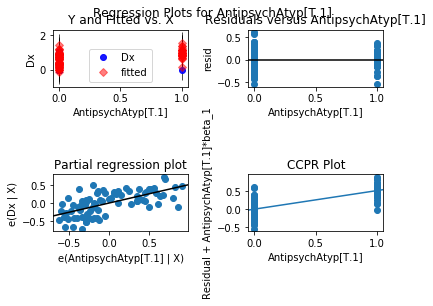

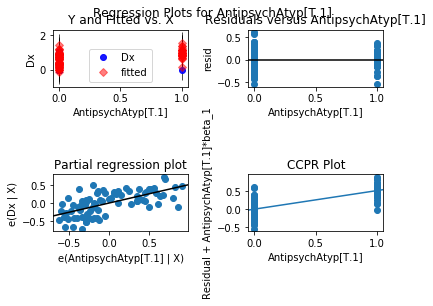

In [15]:
%matplotlib tk
sm.graphics.plot_regress_exog(best, 'AntipsychAtyp[T.1]')

### What about Ethnicity?

To address this question we exclude EV_3 and repeat the forward variable selection

In [16]:
best1 = fwsel.forward_selected(clin1.drop(columns=['EV3']), 'Dx')

In [17]:
best1.model.formula

'Dx ~ AntipsychAtyp + YearofAutopsy + AntipsychTyp + Ethnicity + Institution + Benzodiazepines + causeOfDeath + ReportedGender + Alcohol + PMIinhours + 1'

Recall the previous formula

In [18]:
best.model.formula

'Dx ~ AntipsychAtyp + YearofAutopsy + AntipsychTyp + EV3 + Institution + Benzodiazepines + causeOfDeath + Ethnicity + ReportedGender + Alcohol + PMIinhours + BrainWeightingrams + EV1 + EV4 + 1'

Comparing the new `best1` to the previous `best` we see that Ethinicity has been selected in `best1` instead of EV_5 and EV_2.  EV_4 is still selected in `best1`.

In [19]:
best1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Dx   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     9.957
Date:                Fri, 21 Aug 2020   Prob (F-statistic):           9.43e-12
Time:                        14:28:54   Log-Likelihood:                -7.2283
No. Observations:                  85   AIC:                             44.46
Df Residuals:                      70   BIC:                             81.10
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.6091      0.105      5.796      0.000       0.399       0.819
AntipsychAtyp[T.1]         0.5407      0.075      7.205      0.000       0.391       0.690
AntipsychTyp[T.1]          0.4806      0.094      5.117      0.000       0.293       0.668
Ethnicity[T.Caucasian]    -0.0314      0.101     -0.312      0.756      -0.232       0.169
Ethnicity[T.Hispanic]     -0.9010      0.230     -3.910      0.000      -1.361      -0.441
Institution[T.Pitt]       -0.2470      0.090     -2.751      0.008      -0.426      -0.068
Benzodiazepines[T.1]      -0.2299      0.095     -2.426      0.018      -0.419      -0.041
causeOfDeath[T.2]          0.3762      0.225      1.674      0.099      -0.072       0.824
causeOfDeath[T.3]          0.5511      0.228      2.417      0.018       0.096       1.006
causeOfDeath[T.4]          0.0572      0.213      0.269      0.789      -0.367       0.481
causeOfDeath[T.5]          0.1385      0.109      1.270      0.208      -0.079       0.356
ReportedGender[T.Male]    -0.1400      0.072     -1.938      0.057      -0.284       0.004
Alcohol[T.1]               0.1559      0.091      1.719      0.090      -0.025       0.337
YearofAutopsy             -0.2026      0.039     -5.154      0.000      -0.281      -0.124
PMIinhours                 0.0472      0.033      1.419      0.160      -0.019       0.114
==============================================================================
Omnibus:                        0.420   Durbin-Watson:                   2.106
Prob(Omnibus):                  0.810   Jarque-Bera (JB):                0.581
Skew:                           0.078   Prob(JB):                        0.748
Kurtosis:                       2.626   Cond. No.                         12.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The summary shows that including EV_3 is beneficial for fit (R-squared, Adj. R-squared, AIC, BIC) although the effect is not enormous.

## Conclusions

* Much of the CMC clinical data is missing.  Filtering removed most variables leaving about a dozen, some of which had one missing valueh, which were imputed using the sample mean (or mode for categorical variables)
* Reported Gender and Sex are nearly identical.  Sex is a three level factor: XX, XY and XXY. The third level, XXY, occurs in only one individual, a schizophrenic male with Klinefelter syndrome.  To avoid colinearity between these two variables one of them needs to be removed.  Removing Sex leaves the simpler (two level) Reported Gender in the data set.
* The remaining 12 variables were split to 1 response (`Dx`) and 11 explanatory variables.  8/11 explanatory variables were selected with a forward strategy using normal linear models and adjusted R-squared as score.
* Among the 8 selected explanatory variables only AntipsychAtyp, AntipsychAtyp, Alcohol and Ancestry EV.3 (or Ethinicity if EV.3 has been omitted) had significant ($p \le 0.01$) "effect" on disease status.  Not quite significant effects were displayed by Institution and Gender.
* AntipsychAtyp, AntipsychAtyp might be assumed to be an *a posteriori* conditions relative to the onset of schizophrenia.  That assumption means they do not carry risk for schizophrenia.  On the other hand, Ancestry (Ethinicity) is clearly an *a priori* condition and as the regression coefficient's t-statistic suggests being African American carries risk relative to Hispanic individuals.
* Thus *a posteriori* explanatory variables may or may not be included in further analyses. 
    * If they *are* included they improve fit
    * If they are *not* included they might confound inference.  Despite that excluding all clinical variables (except individual ID) is beneficial because ordinary least squares (OLS) can be used instead of generalized ones (GLS).

In [20]:
%connect_info

{
  "shell_port": 32901,
  "iopub_port": 43751,
  "stdin_port": 39255,
  "control_port": 53817,
  "hb_port": 47335,
  "ip": "127.0.0.1",
  "key": "5e29c81c-2a2b6274b284cb07c35dc5de",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-59afaff0-34a8-43b0-81ec-3c3f1a2fa640.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
